# This notebook analyses data from Bpod.

## Tested on output of protocol 'Two_Alternative_Choice'

***
** Import stuff and select animals **
***

In [2]:
%load_ext autoreload
%autoreload 2
from utils import custom_functions, plot_utils, Lapse_model
import os
import sys
sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain

warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'utils'

In [3]:
# output a list of animals ready to pull
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Behavioural data
GeneralDirectory = '/Volumes/Mouseblaster/SJLab/Behaviour/bpod_raw_data'

for AnimalID in os.listdir(GeneralDirectory):
    DFfile = GeneralDirectory + AnimalID + BpodProtocol + 'Data_Analysis/' + AnimalID + '_dataframe.pkl'
    if os.path.exists(DFfile):
        print('Found data for ' + AnimalID)


NameError: name 'os' is not defined

In [29]:
# Select animals to analyze
#AnimalIDList = ['C01', 'C02', 'C03', 'Ot01', 'Ot02', 'Ot03', 'Os02', 'Os03']
#AnimalIDList = ['C01', 'C02', 'C03', 'N01', 'N02', 'N03', 'N05']
AnimalIDList = ['D1cre01', 'D1cre02', 'D1cre03', 'D1cre04', 'D1cre05', 'D1cre06', 'DRD101', 'DRD102', 'DRD103']

DataFrames = []
# Read the dataframes and merge them
for AnimalID in AnimalIDList:
    DFfile = GeneralDirectory + AnimalID + BpodProtocol + 'Data_Analysis/' + AnimalID + '_dataframe.pkl'
    AnimalDF = pd.read_pickle(DFfile)
    DataFrames.append(AnimalDF)
AnimalsDF = pd.concat(DataFrames, ignore_index=True)

# Create out directory if it does not exist
outputDir = GeneralDirectory + '-'.join(AnimalIDList) + '_Analysis/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

In [30]:
AnimalsDF

,AnimalID,SessionTime,Protocol,Stimulation,Muscimol,CenterPortDuration,Contingency,RewardAmount,TrialIndex,TrialHighPerc,...,FirstPoke,TrialSide,TrialSequence,ResponseTime,TrialStartTimestamp,CumulativePerformance,SwitchSide,PreviousChoice,TrialEvents,TrialStates
0,D1cre01,Aug22 16:16,Habituation,NoStimulation,No,0.1,1,4,0,98.0,...,1.0,1.0,1.0,3.2405,7.1973,100.000000,1,NaN,"{'Tup': [0.01, 52.1689, 55.5132, 55.5133], 'Po...","{'TrialStart': [0.0, 0.01], 'WaitForPoke': [0...."
1,D1cre01,Aug22 16:16,Habituation,NoStimulation,No,0.1,1,4,1,98.0,...,2.0,1.0,1.0,23.0145,62.8241,50.000000,0,1.0,"{'Tup': [0.01, 58.298199999999994, 81.49980000...","{'TrialStart': [0.0, 0.01], 'WaitForPoke': [0...."
2,D1cre01,Aug22 16:16,Habituation,NoStimulation,No,0.1,1,4,2,2.0,...,2.0,2.0,7.0,7.7064,144.4191,66.666667,1,2.0,"{'Tup': [0.01, 47.3767, 55.2362, 55.2363], 'Po...","{'TrialStart': [0.0, 0.01], 'WaitForPoke': [0...."
3,D1cre01,Aug22 16:16,Habituation,NoStimulation,No,0.1,1,4,3,98.0,...,NaN,1.0,1.0,30.0000,199.7440,66.666667,1,2.0,"{'Tup': [0.01, 70.12689999999999, 100.34819999...","{'TrialStart': [0.0, 0.01], 'WaitForPoke': [0...."
4,D1cre01,Aug22 16:16,Habituation,NoStimulation,No,0.1,1,4,4,2.0,...,NaN,2.0,7.0,30.0000,300.1777,66.666667,1,NaN,"{'Tup': [0.01, 293.1226, 323.266], 'Port3In': ...","{'TrialStart': [0.0, 0.01], 'WaitForPoke': [0...."
5,D1cre01,Aug22 16:16,Habituation,NoStimulation,No,0.1,1,4,5,2.0,...,NaN,2.0,7.0,30.0000,623.5244,66.666667,0,NaN,"{'Tup': [0.01, 205.609, 235.7509], 'Port2In': ...","{'TrialStart': [0.0, 0.01], 'WaitForPoke': [[0..."
6,D1cre01,Aug22 16:16,Habituation,NoStimulation,No,0.1,1,4,6,98.0,...,NaN,1.0,1.0,30.0000,859.3575,66.666667,1,NaN,"{'Tup': [0.01, 197.80010000000001, 228.3117], ...","{'TrialStart': [0.0, 0.01], 'WaitForPoke': [0...."
7,D1cre01,Aug22 16:16,Habituation,NoStimulation,No,0.1,1,4,7,98.0,...,2.0,1.0,1.0,6.9627,1087.7555,50.000000,0,NaN,"{'Tup': [0.01, 75.873, 82.9385, 82.93860000000...","{'TrialStart': [0.0, 0.01], 'WaitForPoke': [0...."
8,D1cre01,Aug22 16:16,Habituation,NoStimulation,No,0.1,1,4,8,98.0,...,2.0,1.0,1.0,16.2031,1170.7810,40.000000,0,2.0,"{'Tup': [0.01, 26.429299999999998, 42.7586, 42...","{'TrialStart': [0.0, 0.01], 'WaitForPoke': [0...."
9,D1cre01,Aug22 16:16,Habituation,NoStimulation,No,0.1,1,4,9,98.0,...,2.0,1.0,1.0,1.3264,1213.6203,33.333333,0,2.0,"{'Tup': [0.01, 165.5135, 167.0577, 167.0578], ...","{'TrialStart': [0.0, 0.01], 'WaitForPoke': [0...."


In [31]:
# Create a unique ID for every session
def mergeStrings(df):
    return df['AnimalID'] + ' ' + df['SessionTime']

AnimalsDF['SessionID'] = AnimalsDF[['AnimalID', 'SessionTime']].apply(mergeStrings, axis=1)

In [32]:
# Create a cumulative trial number for every animal BE AWARE THAT SESSIONS MIGHT HAVE BEEN REMOVED BEFORE SO THIS NUMBER IS NOT EXACT
CumTrialsList = []
for Aid in pd.unique(AnimalsDF['AnimalID']):
    CumTrialsList.append(np.arange(len(AnimalsDF[AnimalsDF['AnimalID']==Aid])) + 1)
# flatten the list of lists
AnimalsDF['CumulativeTrialNumber'] = np.array(list(chain(*[x for x in CumTrialsList])))

In [33]:
# Make a column with the group each mouse is in


def AssignToGroup(df):
    # Copy the AnimalIDList
    #AnimalIDList = ['C01', 'C02', 'C03', 'N01', 'N02', 'N03', 'N05']
    AnimalIDList = ['D1cre01', 'D1cre02', 'D1cre03', 'D1cre04', 'D1cre05', 'D1cre06', 'DRD101', 'DRD102', 'DRD103']

    # Create a vector here that is like the AnimalIDList
    #AnimalGroup = ['CortexBuffer', 'CortexBuffer', 'CortexBuffer', 'NMDA', 'NMDA', 'NMDA', 'NMDA']
    AnimalGroup = ['D1Caspase', 'D1Caspase', 'D1Caspase', 'D1Caspase', 'D1Caspase', 'D1Caspase', 'CTXBuffer', 'CTXBuffer', 'CTXBuffer']
    # Index position
    IndxPos = AnimalIDList.index(df['AnimalID'])
    return AnimalGroup[IndxPos]



AnimalsDF['Injection'] = AnimalsDF.apply(AssignToGroup, axis=1)

In [34]:
# Save the dataframe
AnimalDF.to_pickle(outputDir + '-'.join(AnimalIDList) + '_dataframe.pkl')

In [35]:
# plot the behavioral performance on the easy trials as a function of trials


***
**Plot the evolution of the cumulative performance**
***

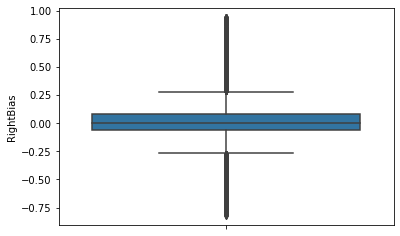

In [36]:
# Calculate the right bias
AnimalsDF['RightBias'] = custom_functions.CalculateRBiasWindow(np.array(AnimalsDF['FirstPoke']),\
                                                              np.array(AnimalsDF['FirstPokeCorrect']), 50)

sns.boxplot(y='RightBias', data=AnimalsDF)

In [37]:
#Select conditions

# include only the easy trials
condition1 = np.logical_or(AnimalsDF['TrialSequence']==1, AnimalsDF['TrialSequence']==7)
# include only trials without stimulation
condition2 = AnimalsDF['OptoStim'] == 0
# remove trials in which the animal is too biased
RBlimit = 1
condition3 = np.logical_and(AnimalsDF['RightBias']>(-RBlimit), AnimalsDF['RightBias']<(RBlimit))

conditions = np.logical_and(np.logical_and(condition1, condition2), condition3)

In [38]:
AnimalsDF[conditions].describe()

,CenterPortDuration,Contingency,RewardAmount,TrialIndex,TrialHighPerc,Outcomes,OptoStim,FirstPokeCorrect,FirstPoke,TrialSide,TrialSequence,ResponseTime,TrialStartTimestamp,CumulativePerformance,SwitchSide,PreviousChoice,CumulativeTrialNumber,RightBias
count,91763.0,91763.0,91763.000000,91763.000000,91763.000000,91763.000000,91763.0,90574.000000,90574.000000,91763.000000,91763.000000,91763.000000,91763.000000,91742.000000,91763.000000,90400.000000,91763.000000,91763.000000
mean,0.1,1.0,2.036289,274.893890,50.116648,0.837157,0.0,0.734681,1.508855,1.498785,3.992709,0.623226,1705.047552,71.597066,0.482133,1.508838,5265.614463,0.009331
std,0.0,0.0,0.205182,203.085716,48.000120,0.462679,0.0,0.441505,0.499924,0.500001,3.000007,1.847212,1398.547985,18.259799,0.499683,0.499925,3216.992945,0.157560
min,0.1,1.0,2.000000,0.000000,2.000000,0.000000,0.0,0.000000,1.000000,1.000000,1.000000,0.116000,1.581500,0.000000,0.000000,1.000000,1.000000,-0.820000
25%,0.1,1.0,2.000000,113.000000,2.000000,1.000000,0.0,0.000000,1.000000,1.000000,1.000000,0.219400,649.313100,55.555556,0.000000,1.000000,2555.000000,-0.060000
50%,0.1,1.0,2.000000,238.000000,98.000000,1.000000,0.0,1.000000,2.000000,1.000000,1.000000,0.289200,1319.334600,69.444444,0.000000,2.000000,5104.000000,0.000000
75%,0.1,1.0,2.000000,398.000000,98.000000,1.000000,0.0,1.000000,2.000000,2.000000,7.000000,0.442900,2421.355600,89.310959,1.000000,2.000000,7696.000000,0.080000
max,0.1,1.0,5.000000,1354.000000,98.000000,3.000000,0.0,1.000000,2.000000,2.000000,7.000000,30.000000,9373.753200,100.000000,1.000000,2.000000,13915.000000,0.940000


In [39]:
# Calculate the performance based on these trials only
EasyDF = AnimalsDF[conditions]

# calculate the cumulative performance
def CumPerCalculator(df):
    firstpokecorrect = df['FirstPokeCorrect']
    correct_cp = np.cumsum(firstpokecorrect == 1)
    incorrect_cp = np.cumsum(firstpokecorrect == 0)
    cumper = 100 * correct_cp / (correct_cp + incorrect_cp)
    return cumper

CumPerList = []
for Sid in pd.unique(EasyDF['SessionID']):
    CumPerList.append(CumPerCalculator(EasyDF[EasyDF['SessionID']==Sid]))
# flatten the list of lists
EasyDF['CumulativePerformance'] = np.array(list(chain(*[x for x in CumPerList])))


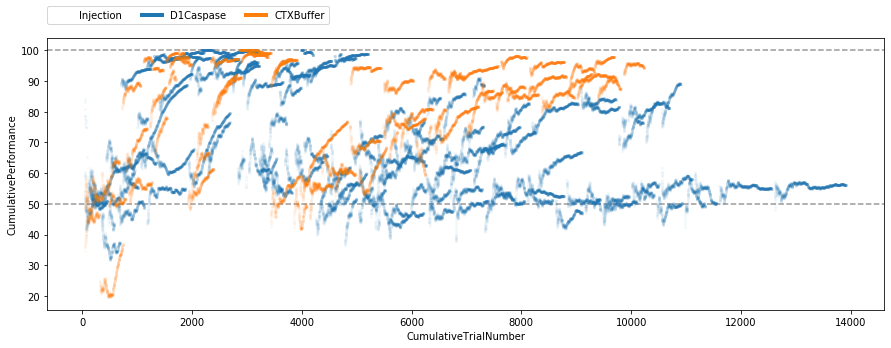

In [40]:
# remove the trials at the beginning of the session because it makes it noisy
condition4 = EasyDF['TrialIndex'] > 50

# remove the Aud_Psycho
condition5 = ~(EasyDF['Protocol'] == 'Aud_Psycho')

fig, ax = plt.subplots(figsize=(15,5))
ax.axhline(50, ls='--', alpha=0.4, color='k')
ax.axhline(100, ls='--', alpha=0.4, color='k')
sns.lineplot(x='CumulativeTrialNumber', y='CumulativePerformance', data=EasyDF[np.logical_and(condition4, condition5)],
             hue='Injection', marker=".", alpha=0.05, markeredgewidth=0, linewidth=0,
             units="AnimalID", estimator=None)

lgd = plt.legend(ncol=4, loc=(0,1.05), borderaxespad=0.)
for l in lgd.get_lines():
    l.set_alpha(1)
    l.set_linewidth(4)

plt.savefig(outputDir + 'CumulativePerformance.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [41]:
# Restart the count of CumulativeTrialNumber for every protocol and plot in different rows sharing x axis
EasyDF['CumulativeTrialNumberByProtocol'] = np.nan

for Aid in pd.unique(EasyDF['AnimalID']):
    for Prot in pd.unique(EasyDF['Protocol']):
        conditions = np.logical_and(EasyDF['AnimalID']==Aid, EasyDF['Protocol']==Prot)
        EasyDF.CumulativeTrialNumberByProtocol.loc[EasyDF[conditions].index] = \
        np.arange(len(EasyDF[conditions])) + 1
            

NameError: name 'lgd' is not defined

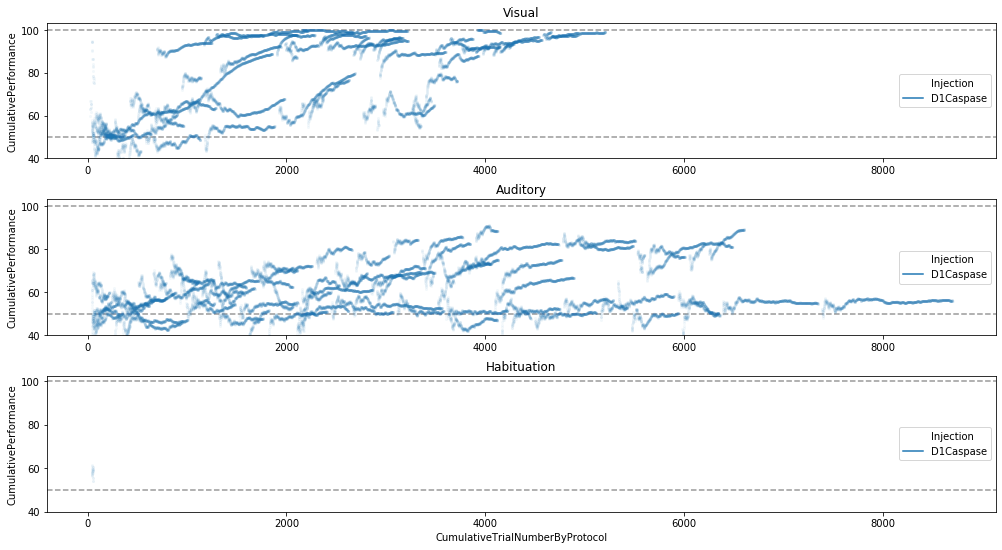

In [21]:
# remove the trials at the beginning of the session because it makes it noisy
condition4 = EasyDF['TrialIndex'] > 40

fig, axs = plt.subplots(len(pd.unique(EasyDF['Protocol'])), 1, figsize=(17,3 * len(pd.unique(EasyDF['Protocol']))), sharex=True)
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3)
for ax in axs:
    ax.axhline(50, ls='--', alpha=0.4, color='k')
    ax.axhline(100, ls='--', alpha=0.4, color='k')

for ax, prot in enumerate(pd.unique(EasyDF['Protocol'])):
    sns.lineplot(x='CumulativeTrialNumberByProtocol', y='CumulativePerformance',
                 data=EasyDF[np.logical_and(condition4, EasyDF['Protocol']==prot)],
                 ax=axs[ax], hue='Injection', 
                 marker=".", alpha=0.05, markeredgewidth=0, linewidth=0,
                 # the following line splits the data and does not compute confidence intervals and mean
                 units="AnimalID", estimator=None)
                
    axs[ax].set_title(prot)
    axs[ax].set_ylim(bottom=40)
    '''
    lgd = axs[ax].legend(ncol=4, loc=(0,1.05), borderaxespad=0.)
    for l in lgd.get_lines():
        l.set_alpha(1)
        l.set_linewidth(4)
    '''
for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
plt.savefig(outputDir + 'CumulativePerformanceByProtocol_Group.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.show()

Create a simpler plot calculating the performance of the day


In [22]:
# Day of training
def getDay(df):
    return df.SessionTime.split(' ')[0]
    
AnimalsDF['TrainingDay'] = AnimalsDF.apply(getDay, axis=1)

In [23]:
# generate a new dataset to get the data
dfForPlot = custom_functions.AnalyzePercentageByDay(AnimalsDF)

In [24]:
dfForPlot

,AnimalID,SessionTime,PercCorrect,Protocol,Injection
0,D1cre01,Aug22,30.303030,Habituation,D1Caspase
1,D1cre01,Aug23,48.076923,Visual,D1Caspase
2,D1cre01,Aug24,50.498339,Visual,D1Caspase
3,D1cre01,Aug26,68.712871,Visual,D1Caspase
4,D1cre01,Aug27,67.857143,Visual,D1Caspase
5,D1cre01,Aug28,90.773810,Visual,D1Caspase
6,D1cre01,Aug31,97.107438,Visual,D1Caspase
7,D1cre01,Oct21,57.936508,Visual,D1Caspase
8,D1cre01,Oct22,64.476021,Visual,D1Caspase
9,D1cre01,Oct23,86.907449,Visual,D1Caspase


In [25]:
# For each animal and protocol, calculate the session count for that protocol
# ProtocolCount
dfForPlot['ProtocolCount'] = np.nan
for animal in pd.unique(dfForPlot['AnimalID']):
    for protocol in pd.unique(dfForPlot['Protocol']):
        conditions = np.logical_and(dfForPlot['AnimalID']==animal, dfForPlot['Protocol']==protocol)
        dfForPlot.ProtocolCount.loc[dfForPlot[conditions].index] = \
        np.arange(len(dfForPlot[conditions])) + 1

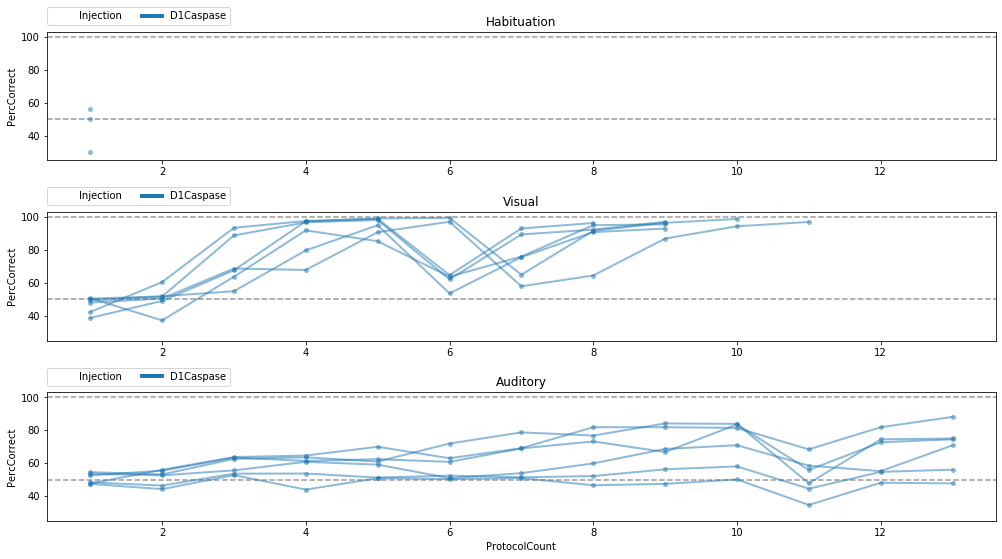

In [26]:
fig, axs = plt.subplots(len(np.unique(dfForPlot['Protocol'])),1, figsize=(17,3*len(np.unique(dfForPlot['Protocol']))), sharex=True)
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.4)
for ax in axs:
    ax.axhline(50, ls='--', alpha=0.4, color='k')
    ax.axhline(100, ls='--', alpha=0.4, color='k')

for ax, prot in enumerate(pd.unique(dfForPlot['Protocol'])):
    sns.lineplot(x='ProtocolCount', y='PercCorrect',
                 data=dfForPlot[dfForPlot['Protocol']==prot],
                 ax=axs[ax], hue='Injection', 
                 marker=".", alpha=0.5, markeredgewidth=0, linewidth=2, markersize=10,
                 # the following line splits the data and does not compute confidence intervals and mean
                 units="AnimalID", estimator=None)
                
    axs[ax].set_title(prot)
    axs[ax].set_ylim(bottom=25)
    
    lgd = axs[ax].legend(ncol=4, loc=(0,1.05), borderaxespad=0.)
    for l in lgd.get_lines():
        l.set_alpha(1)
        l.set_linewidth(4)
    
for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
plt.savefig(outputDir + 'SessionPercCorrectByProtocol.pdf',
            transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

#sns.barplot(x='SessionTime', y='PercCorrect', hue='AnimalID', data=dfForPlot)